In [123]:
import json
import requests
import torch
import random
import numpy as np
from torchvision import models, transforms
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import torch.optim as optim

# Load ImageNet class index if not already available
URL = "https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json"
class_idx = requests.get(URL).json()

# Function to get class label from class index
def get_class_label(idx):
    return class_idx[str(idx)][1]


In [124]:
# Function to get class label from class index
def get_class_label(idx):
    return class_idx[str(idx)][1]

def random_classifier(x):
    return torch.rand((1, 1000), requires_grad=True)  # Changed function name and output size

def adversarial_loss(output, target):
    target_score = output[0, target]
    return -target_score

def draw_mask(center, rays, angles, image_size):
    image = Image.new('L', image_size, 0)
    draw = ImageDraw.Draw(image)
    for angle, ray in zip(angles, rays):
        end_x = int(center[0] + ray * np.cos(angle))
        end_y = int(center[1] + ray * np.sin(angle))
        draw.line([center, (end_x, end_y)], fill=255, width=5)  # Decreased line width
    return np.array(image)


In [125]:
def generate_adversarial_patch(target_class, iterations=5000, lr=0.1):
    center = (250, 250)
    image_size = (500, 500)
    angles = np.linspace(0, 2 * np.pi, 20, endpoint=False)
    rays = np.random.uniform(20, 150, 40)  # Adjusted ray range
    texture = torch.rand(3, *image_size, requires_grad=True)
    optimizer = optim.Adam([texture], lr=lr)

    for i in range(iterations):
        optimizer.zero_grad()
        output = random_classifier(texture)
        loss = adversarial_loss(output, target_class)
        (-loss).backward()  # Negate loss for gradient ascent
        optimizer.step()

    mask = draw_mask(center, rays, angles, image_size)
    mask_tensor = torch.from_numpy(mask).to(torch.float32).unsqueeze(0) / 255.0
    patch_array = texture.detach() * mask_tensor
    patch_array = patch_array.permute(1, 2, 0).numpy()
    return patch_array

In [126]:
def load_image(image_path):
    img = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((300, 300)),  # Resized image for better visualization
        transforms.ToTensor()
    ])
    return transform(img).unsqueeze(0)

In [120]:
# Load VGG model
model = models.vgg16(pretrained=True)
model.eval()

# Load and prepare the image
image_path = input("\nEnter Your image name or path: ")
input_image = load_image(image_path)



Enter Your image name or path: tree.jpeg


In [127]:
# Predict original image
original_output = model(input_image)
original_class = original_output.argmax().item()
original_label = get_class_label(original_class)

# Generate and apply the patch
target_class = 56  # Target class for the adversarial patch
patch = generate_adversarial_patch(target_class, iterations=5000, lr=0.1)  # Increased iterations and adjusted lr
patch = torch.tensor(patch).permute(2, 0, 1)  # Convert patch to tensor and permute dimensions
patch = transforms.Resize((300, 300))(patch)  # Resize patch to match input image size
patched_image = input_image + patch  # Add patch to input image


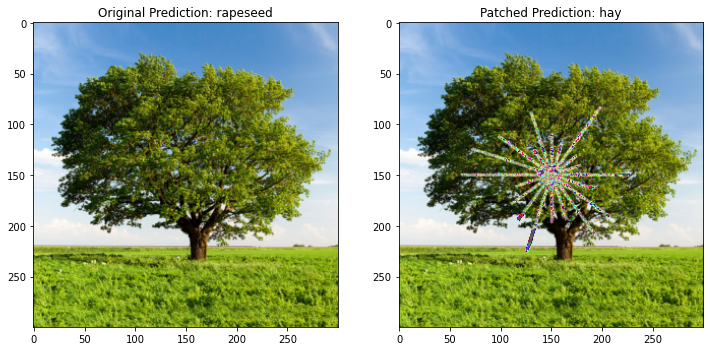

In [128]:
# Predict patched image
patched_output = model(patched_image)
patched_class = patched_output.argmax().item()
patched_label = get_class_label(patched_class)

# Save patched image
save_img = transforms.ToPILImage()(patched_image.squeeze(0))
save_img.save("patched_image.jpg")

# Display results
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(transforms.ToPILImage()(input_image.squeeze(0)))
ax[0].set_title(f"Original Prediction: {original_label}")
ax[1].imshow(save_img)
ax[1].set_title(f"Patched Prediction: {patched_label}")
plt.show()